# Added mass - convergence

In [1]:
using ViscousFlow

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
using LinearAlgebra

In [4]:
function surface_integrate(body::Body{N},integrand::Array{Float64,1}) where {N}
    func = Array{Float64,1}(undef, N+1)
    func[1:end-1] .= integrand
    func[end] = integrand[1]
    s = sum(Bodies.dlength(body).*(func[1:end-1] + func[2:end]))
    return s
end

surface_integrate (generic function with 1 method)

In [5]:
𝐞₁ = [1;0];
𝐞₂ = [0;1];

In [9]:
sizes = [2^k for k in 4:9]
# gridN = 512
i = 0
error_M11 = Array{Float64,1}(undef, length(sizes))
error_M22 = Array{Float64,1}(undef, length(sizes))

a = 0.5
b = 0.75

for gridN in sizes
    i = i+1;
    nx = gridN; ny = gridN;
    Lx = 2.0;
    dx = Lx/(nx-2);
    w = Nodes(Dual,(nx,ny));

    L = plan_laplacian(size(w),with_inverse=true)

    n = Int(floor(2*π*b*nx/Lx))
    body = Ellipse(a,b,n)

    # Find the minimum arc length
    ds = minimum(Bodies.dlength(body))

    # Move the ellipse
    xc = 1.0; yc = 1.0
    T = RigidTransform((xc,yc),0.0)
    T(body)

    # Area of the ellipse
    𝒱 = π*body.a*body.b

    X = VectorData(body.x,body.y)
    f = ScalarData(X);

    E = Regularize(X,dx;issymmetric=true)
    Hmat,Emat = RegularizationMatrix(E,f,w);

    L⁻¹(w::T) where {T} = L\w
    PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true)

    ψb = ScalarData(X)
    w = Nodes(Dual,(nx,ny))
    ψ = Nodes(Dual,w);
  
    # Horizontal unit translation
    U = 1;
    V = 0;

    ψb .= U*(body.y .- body.cent[2]) - V*(body.x .- body.cent[1])
    ψ,f = PS\(w,ψb)

    integrand_x = (f./Bodies.dlength(body)).*(body.y);
    integrand_y = -(f./Bodies.dlength(body)).*(body.x);

    P¹ = -𝒱*𝐞₁ + 0.5*[surface_integrate(body,integrand_x);surface_integrate(body,integrand_y)]

    M₁₁ = dot(P¹,𝐞₁)
    M₁₂ = dot(P¹,𝐞₂)
    
    error_M11[i] = M₁₁ - π*b^2;
    
    # Vertical unit translation
    U = 0;
    V = 1;

    ψb .= U*(body.y .- body.cent[2]) - V*(body.x .- body.cent[1])
    ψ,f = PS\(w,ψb)

    integrand_x = (f./Bodies.dlength(body)).*(body.y);
    integrand_y = -(f./Bodies.dlength(body)).*(body.x);

    P² = -𝒱*𝐞₂ + 0.5*[surface_integrate(body,integrand_x);surface_integrate(body,integrand_y)]

    M₂₁ = dot(P²,𝐞₁)
    M₂₂ = dot(P²,𝐞₂)
    
    error_M22[i] = M₂₂ - π*a^2;

    println("nx = ny = $(nx); n = $(n); ds/dx = $(ds/dx);\nM₁₁ = $(M₁₁)\nM₁₂ = $(M₁₂)\nM₂₁ = $(M₂₁)\nM₂₂ = $(M₂₂)\n")
end

println("exact solution:\nM₁₁ = $(π*b^2)\nM₁₂ = 0\nM₂₁ = 0\nM₂₂ = $(π*a^2)\n")

nx = ny = 16; n = 37; ds/dx = 0.5943094081265577;
M₁₁ = 2.238787288877447
M₁₂ = -0.035524497883116075
M₂₁ = -0.06514301796017238
M₂₂ = 1.1770709867613949

nx = ny = 32; n = 75; ds/dx = 0.6283069638911408;
M₁₁ = 1.9687538367391104
M₁₂ = -0.017132707406643327
M₂₁ = -0.02741975514191873
M₂₂ = 0.9503652011795345

nx = ny = 64; n = 150; ds/dx = 0.6492150163840529;
M₁₁ = 1.8611229707124517
M₁₂ = -0.008400405481434097
M₂₁ = -0.012989632579710489
M₂₂ = 0.8618914161001126

nx = ny = 128; n = 301; ds/dx = 0.6575419019522546;
M₁₁ = 1.812586976965271
M₁₂ = -0.004142746164886867
M₂₁ = -0.006300656053046003
M₂₂ = 0.8222837091803337

nx = ny = 256; n = 603; ds/dx = 0.6616619472360098;
M₁₁ = 1.7894905600909903
M₁₂ = -0.0020614215868918657
M₂₁ = -0.003108551133233434
M₂₂ = 0.8035221728032778

nx = ny = 512; n = 1206; ds/dx = 0.6642663521001764;
M₁₁ = 1.7782290055502972
M₁₂ = -0.001026813683160377
M₂₁ = -0.001541465724964032
M₂₂ = 0.7943798485900044

exact solution:
M₁₁ = 1.7671458676442586
M₁₂ = 0
M₂₁ 

Plot streamfunction

In [10]:
# xg,yg = coordinates(ψ,dx=dx)
# plot(xg,yg,ψ,linecolor=:black,levels=range(-1,1,length=31))
# plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

Log-log errorplot

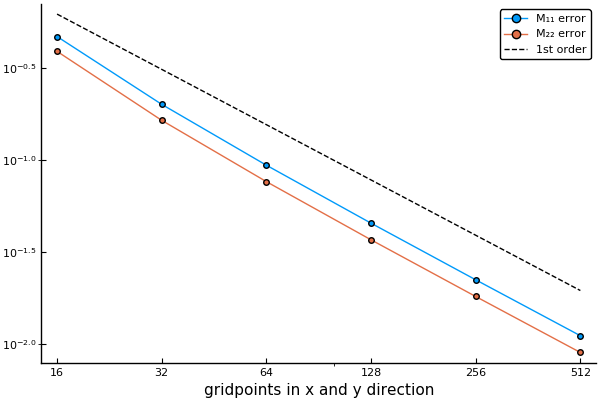

In [11]:
error_firstorder=(1.0e1./sizes).^1
# error_secondorder=(1.0e1./sizes).^2
xlab = ["$(sizes[i])" for i in 1:length(sizes)]; 
plot(sizes,error_M11,xaxis=:log,yaxis=:log,xticks=(sizes,xlab),marker=:circle,lab="M₁₁ error")
plot!(sizes,error_M22,xaxis=:log,yaxis=:log,xticks=(sizes,xlab),marker=:circle,lab="M₂₂ error")
plot!(sizes,error_firstorder,lab="1st order",xlabel="gridpoints in x and y direction",linestyle=:dash,linecolor=:black)
# plot!(sizes,error_secondorder,lab="2nd order")